In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=b9ba22d3fa27806cff4b6893a00e9c01a123ba1a6bcd6ba0e472ad5a9a186d8b
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("StockSense") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/12 19:36:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
from pyspark.sql.functions import col

# Load the CSV file
df = spark.read.csv("/kaggle/input/apple-stocks/AAPL.csv", header=True, inferSchema=True)

# Select the 'close' column and reset the index
df1 = df.select(col("close").alias("label"))

In [4]:
# Convert to Pandas DataFrame for plotting
pandas_df1 = df1.toPandas()

In [5]:
pandas_df1.head()

,label
0,132.045
1,131.780
2,130.280
3,130.535
4,129.960


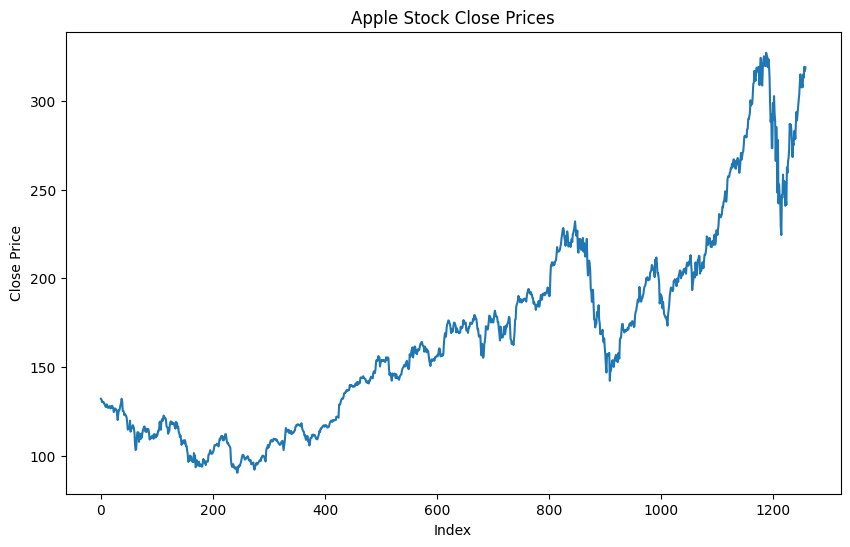

In [6]:
import matplotlib.pyplot as plt
#Plot the data
plt.figure(figsize=(10,6))
plt.plot(pandas_df1['label'])
plt.title('Apple Stock Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))
pandas_df1=scaler.fit_transform(np.array(pandas_df1).reshape(-1,1))

In [8]:
print(pandas_df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In [9]:
# Splitting dataset into train and test split
training_size = int(len(pandas_df1) * 0.65)
train_data = pandas_df1[0:training_size]
test_data = pandas_df1[training_size:len(pandas_df1)]

In [10]:
# Function to create dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [12]:
# Reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [13]:
# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [14]:
spark.stop()

In [15]:
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(716, 100, 1)
(716,)
(340, 100, 1)
(340,)


(None, None)

In [16]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 23.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Assuming X_train, y_train, X_test, y_test are available from the preprocessing step

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

2024-07-12 19:37:48.424362: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 19:37:48.424471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 19:37:48.581005: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Train the model
model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1)

Epoch 1/100


I0000 00:00:1720813093.668096     267 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 [==============================] - 5s 16ms/step - loss: 0.0229
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 0.0042
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 9.7305e-04
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 6.4932e-04
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 4.6042e-04
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 4.1460e-04
Epoch 7/100
12/12 [==============================] - 0s 9ms/step - loss: 4.0629e-04
Epoch 8/100
12/12 [==============================] - 0s 9ms/step - loss: 4.0122e-04
Epoch 9/100
12/12 [==============================] - 0s 9ms/step - loss: 3.9430e-04
Epoch 10/100
12/12 [==============================] - 0s 9ms/step - loss: 3.9009e-04
Epoch 11/100
12/12 [==============================] - 0s 9ms/step - loss: 3.8601e-04
Epoch 12/100
12/12 [==============================] - 0s 9ms/step - loss: 3.8272e-04
Epoch 

In [20]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

11/11 [==============================] - 0s 6ms/step


In [22]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [23]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

33958.57584507411

In [24]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,test_predict))

56755.48870443019

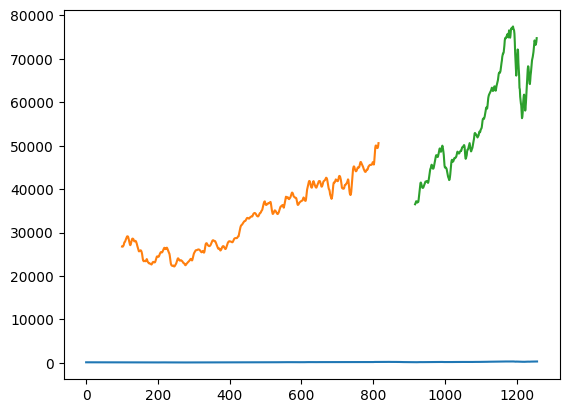

In [25]:
import numpy as np
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(pandas_df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(pandas_df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(pandas_df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(pandas_df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [26]:
len(test_data)

441

In [27]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [28]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [29]:
temp_input

[0.8583551465000423,
 0.8866418981676942,
 0.8743139407244789,
 0.8843198513890065,
 0.8783669678290975,
 0.8986321033521913,
 0.925821160179009,
 0.9287764924427933,
 0.9567677108840666,
 0.9386979650426415,
 0.933040614709111,
 0.9495060373216249,
 0.9642404796082076,
 0.9551211686228154,
 0.9598919192772104,
 0.9663514312251966,
 0.9624672802499368,
 0.9229502659799038,
 0.9598497002448705,
 0.9879253567508233,
 0.985941062230854,
 0.9253145317909315,
 0.9217259140420504,
 0.964747107996285,
 0.9757240564046274,
 0.9915984125643842,
 0.9697289538123788,
 0.9761462467280253,
 0.9679557544541082,
 1.0000000000000002,
 0.9901629654648318,
 0.9905007177235499,
 0.9653803934813816,
 0.9848855864223593,
 0.9708688676855528,
 0.9402600692392133,
 0.8774803681499621,
 0.8348391454867856,
 0.8541332432660644,
 0.7733682344000676,
 0.7726927298826314,
 0.8801401671873683,
 0.8400743054969182,
 0.8967322468969012,
 0.8552731571392387,
 0.8388499535590646,
 0.7423372456303303,
 0.82327113062568

In [30]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9697545]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

In [31]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [32]:
import matplotlib.pyplot as plt

In [33]:
print(pandas_df1)

[[0.17607447]
 [0.17495567]
 [0.16862282]
 ...
 [0.96635143]
 [0.9563033 ]
 [0.96491598]]


In [34]:
print(day_pred)

[101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120 121 122 123 124 125 126 127 128 129 130]


In [35]:
print(pandas_df1[1158:])

[[0.85835515]
 [0.8866419 ]
 [0.87431394]
 [0.88431985]
 [0.87836697]
 [0.8986321 ]
 [0.92582116]
 [0.92877649]
 [0.95676771]
 [0.93869797]
 [0.93304061]
 [0.94950604]
 [0.96424048]
 [0.95512117]
 [0.95989192]
 [0.96635143]
 [0.96246728]
 [0.92295027]
 [0.9598497 ]
 [0.98792536]
 [0.98594106]
 [0.92531453]
 [0.92172591]
 [0.96474711]
 [0.97572406]
 [0.99159841]
 [0.96972895]
 [0.97614625]
 [0.96795575]
 [1.        ]
 [0.99016297]
 [0.99050072]
 [0.96538039]
 [0.98488559]
 [0.97086887]
 [0.94026007]
 [0.87748037]
 [0.83483915]
 [0.85413324]
 [0.77336823]
 [0.77269273]
 [0.88014017]
 [0.84007431]
 [0.89673225]
 [0.85527316]
 [0.83884995]
 [0.74233725]
 [0.82327113]
 [0.78143207]
 [0.6665963 ]
 [0.7921557 ]
 [0.64118044]
 [0.68614371]
 [0.66001013]
 [0.65203074]
 [0.58642236]
 [0.56586169]
 [0.66089673]
 [0.65515494]
 [0.70970193]
 [0.66452757]
 [0.69437642]
 [0.69218104]
 [0.63569197]
 [0.65266402]
 [0.63780292]
 [0.7267162 ]
 [0.71388162]
 [0.74191506]
 [0.75002111]
 [0.77222832]
 [0.83

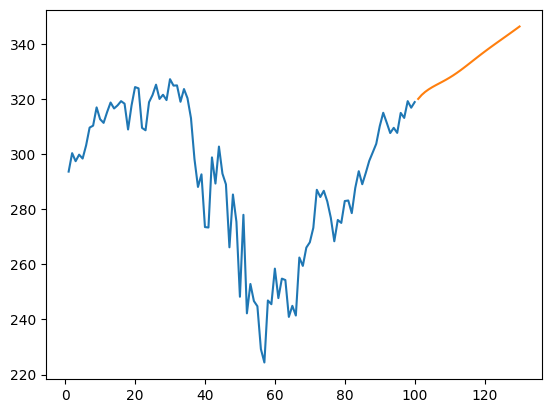

In [36]:
from sklearn.preprocessing import MinMaxScaler
plt.plot(day_new,scaler.inverse_transform(pandas_df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

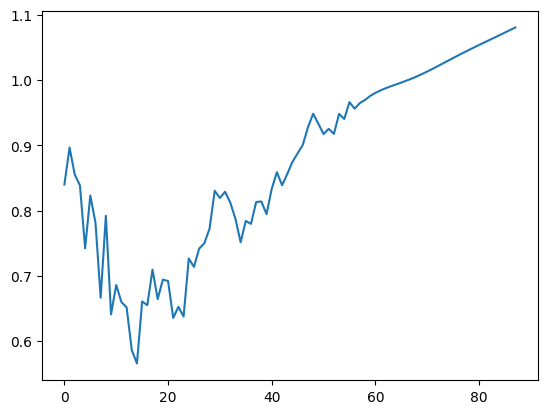

In [37]:
df3=pandas_df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [39]:
df3=scaler.inverse_transform(df3).tolist()

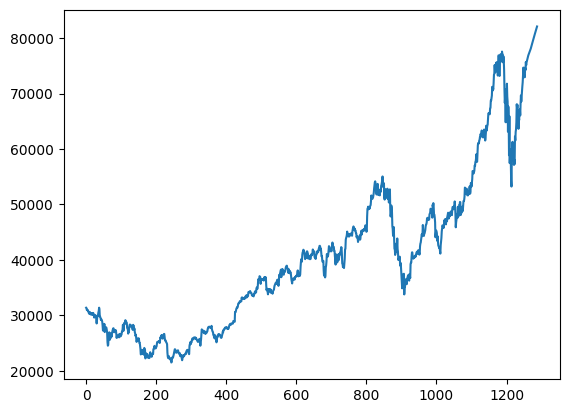

In [40]:
plt.plot(df3)